# Libraries:

In [194]:
# Importing, Engineering, and Transforming data:
import pandas as pd

# Plotting and transforming dates to int:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SVM Model:
from sklearn.svm import SVR

# Model Evaluation:
from sklearn.metrics import mean_squared_error


import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# import pandas_datareader.data as web
import datetime

from matplotlib import style

# ignore warnings 
# import warnings
# warnings.filterwarnings('ignore')

# Basics:
import numpy as np 

# Importing and Formating Data:

## Importing:
Lets import the whole dataframe first:

In [165]:
#Importing dataframe:
# df = pd.read_csv('data/btc_full.csv')
df = pd.read_excel('data/btc_partial_features.xls')
df

,Time,BTC / USD Denominated Closing Price,BTC / Free Float Market Cap (USD),BTC / Realized Market Cap (USD),BTC / Active Market Cap (1yr) (USD),BTC / 30 Day Volatility,BTC / 180 Day Volatility,"BTC / ROI, 1 Year","BTC / ROI, 30 Days",BTC / Annual Inflation Rate,...,BTC / Value in Top 10% of Addrs (native units),BTC / Value in Top 1% of Addrs (native units),BTC / Total Fees (native units),BTC / Miner Revenue (native units),BTC / NVT,BTC / Mean Hash Rate,BTC / Difficulty,BTC / Exchange Deposits (native units),BTC / Exchange Withdrawals (native units),BTC / Miner Supply (native units)
0,2009-01-03,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
1,2009-01-04,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
2,2009-01-05,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
3,2009-01-06,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
4,2009-01-07,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,2021-10-16,60932.063212,8.850671e+11,4.167951e+11,5.282887e+11,0.041404,0.042173,437.367776,27.480061,1.609965,...,1.866171e+07,1.725065e+07,15.434662,846.684662,84.956180,1.315222e+08,1.989305e+13,19749.903680,11579.048564,1.798318e+06
4670,2021-10-17,61462.222372,8.928154e+11,4.174171e+11,5.327219e+11,0.041225,0.042169,440.907262,30.178528,1.936697,...,1.866253e+07,1.725102e+07,11.310294,1011.310294,117.153052,1.582222e+08,1.989305e+13,9566.307540,11389.491044,1.798489e+06
4671,2021-10-18,61977.057551,9.003317e+11,4.204438e+11,5.393226e+11,0.041163,0.042039,439.417698,28.572401,1.791357,...,1.866385e+07,1.725614e+07,15.971247,940.971247,57.017267,1.465815e+08,2.008246e+13,23466.427777,26568.856321,1.798324e+06
4672,2021-10-19,64290.897757,9.340006e+11,4.224533e+11,5.598689e+11,0.041098,0.042009,447.351668,36.156238,1.875987,...,1.866471e+07,1.725672e+07,14.856384,983.606384,57.787489,1.547372e+08,2.008246e+13,33603.268908,39997.994668,1.798231e+06


## Exploring Nulls:
Now let's create a function to look for the row number when each feature starts having continuosly valid data. We will use it later to drop the early datapoints that contains null values: 

In [168]:
# Finding the oldest nulls in the dataframe:
def max_null_df(df):
    '''Returns a dataframe with all the columns and the row number
    of the most recent datapoint that contains a null value.    
    Input: dataframe
    Output: dataframe '''

    max_null_df = pd.DataFrame(columns=['feature', 'oldest_null'])
    i = 0
    for column in df.columns:
        max_null_df.loc[i] = [column, df[df[column].isnull() == True].index.max()]
        i += 1

    return max_null_df[max_null_df['oldest_null'].isnull() == False]

max_null_df(df).sort_values(by='oldest_null', ascending=False)
# max_null_df(df).oldest_null.max()


,feature,oldest_null
7,"BTC / ROI, 1 Year",925
6,BTC / 180 Day Volatility,740
5,BTC / 30 Day Volatility,590
8,"BTC / ROI, 30 Days",590
1,BTC / USD Denominated Closing Price,560
2,BTC / Free Float Market Cap (USD),560
4,BTC / Active Market Cap (1yr) (USD),560
19,BTC / NVT,382
9,BTC / Annual Inflation Rate,5
20,BTC / Mean Hash Rate,5


To complement the null value analysis, lets create a function that shows us the proportion of the data that contains null values:

In [169]:
def null_percentages(df):
    '''Returns a table with the number and percentage of datapoints that
    are null for each column/feature
    Input: dataframe
    Output: dataframe'''

    null_num = df.isnull().sum().sort_values(ascending=False)
    null_perc = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False) * 100
    null_tot = pd.concat([null_num, null_perc], axis=1, keys=['Null #', 'Null %'])
    
    return null_tot[null_tot['Null #'] != 0]

null_percentages(df)

,Null #,Null %
"BTC / ROI, 1 Year",926,19.811724
BTC / 180 Day Volatility,741,15.853659
BTC / 30 Day Volatility,591,12.644416
"BTC / ROI, 30 Days",591,12.644416
BTC / USD Denominated Closing Price,561,12.002567
BTC / Free Float Market Cap (USD),561,12.002567
BTC / Active Market Cap (1yr) (USD),561,12.002567
BTC / NVT,260,5.562687
BTC / Difficulty,6,0.128370
BTC / Mean Hash Rate,6,0.128370


## Preprocessing:
Now lets streamline the dataframe a little and keep just what we are going to use:

In [172]:
# create a function to clean the dataframe:

def preprocessing(df, date_col_name, keep_feat=list(df.columns)):
    '''Formats columns, streamlines, drops nulls.
    Params:
        - keep_feat = the columns that want to keep. Default: all
        - date_col_name = the name of the column with the date on it
    Input: dataframe to transform
    Output: dataframe transformed'''

    processed_df = df.copy()
    # Formatting date and indexing by date:
    processed_df[date_col_name] = pd.to_datetime(processed_df[date_col_name])
    processed_df.set_index(date_col_name, inplace=True, drop=False)

    # convert date to number to use as input for the models:
    processed_df[date_col_name] = processed_df[date_col_name].map(mdates.date2num)

    # Narrowing down Features: DO BEFORE DROPPING NULL
    processed_df = processed_df[keep_feat]

    # dropping obs with null values:
    processed_df = processed_df.iloc[max_null_df(df).oldest_null.max() + 1:]

    # processed_df = processed_df.iloc[max_null_row(processed_df):]



    #filtering dates:
    # processed_df.loc['2015-07-03' : '2015-07-10']
    # processed_df.loc['2015-07-03']
    return processed_df

Lets check if it's working properly:

In [309]:
# Defining the features to keep:
keep_feat = ['date', 'PriceUSD']

In [310]:
# Verifying the processed data:
preprocessing(df, 'Time')

,Time,BTC / USD Denominated Closing Price,BTC / Free Float Market Cap (USD),BTC / Realized Market Cap (USD),BTC / Active Market Cap (1yr) (USD),BTC / 30 Day Volatility,BTC / 180 Day Volatility,"BTC / ROI, 1 Year","BTC / ROI, 30 Days",BTC / Annual Inflation Rate,...,BTC / Value in Top 10% of Addrs (native units),BTC / Value in Top 1% of Addrs (native units),BTC / Total Fees (native units),BTC / Miner Revenue (native units),BTC / NVT,BTC / Mean Hash Rate,BTC / Difficulty,BTC / Exchange Deposits (native units),BTC / Exchange Withdrawals (native units),BTC / Miner Supply (native units)
Time,,,,,,,,,,,,,,,,,,,,,
2011-07-18,15173.0,13.630521,9.334926e+07,4.806681e+07,6.009907e+07,0.039919,0.096840,15778.985613,-19.228477,45.301560,...,5.390557e+06,3.944290e+06,12.946993,8512.946993,19.892789,1.320875e+01,1.563028e+06,262.893448,152.837782,2.269396e+06
2011-07-19,15174.0,13.824795,9.477791e+07,4.824804e+07,6.107027e+07,0.039263,0.095685,17009.894602,-21.049521,37.800938,...,5.421214e+06,3.951875e+06,14.831258,7114.831258,34.786764,1.121117e+01,1.690896e+06,197.801293,160.425876,2.267793e+06
2011-07-20,15175.0,13.678331,9.387571e+07,4.782336e+07,6.048943e+07,0.039237,0.095626,18202.264271,-21.885947,39.621308,...,5.452903e+06,3.960252e+06,10.438026,7460.438026,27.946156,1.252418e+01,1.690896e+06,126.868136,106.318998,2.269000e+06
2011-07-21,15176.0,13.611808,9.352261e+07,4.791077e+07,6.028202e+07,0.039212,0.095621,17088.175785,-22.265841,40.374343,...,5.489839e+06,3.968480e+06,8.860440,7608.860440,49.877146,1.277634e+01,1.690896e+06,190.519838,90.287447,2.269320e+06
2011-07-22,15177.0,13.698547,9.422199e+07,4.799623e+07,6.074844e+07,0.039276,0.095620,23328.430771,-21.770493,40.064697,...,5.517829e+06,3.975949e+06,13.870556,7563.870556,43.467176,1.269229e+01,1.690896e+06,271.838478,89.418930,2.269616e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-16,18916.0,60932.063212,8.850671e+11,4.167951e+11,5.282887e+11,0.041404,0.042173,437.367776,27.480061,1.609965,...,1.866171e+07,1.725065e+07,15.434662,846.684662,84.956180,1.315222e+08,1.989305e+13,19749.903680,11579.048564,1.798318e+06
2021-10-17,18917.0,61462.222372,8.928154e+11,4.174171e+11,5.327219e+11,0.041225,0.042169,440.907262,30.178528,1.936697,...,1.866253e+07,1.725102e+07,11.310294,1011.310294,117.153052,1.582222e+08,1.989305e+13,9566.307540,11389.491044,1.798489e+06
2021-10-18,18918.0,61977.057551,9.003317e+11,4.204438e+11,5.393226e+11,0.041163,0.042039,439.417698,28.572401,1.791357,...,1.866385e+07,1.725614e+07,15.971247,940.971247,57.017267,1.465815e+08,2.008246e+13,23466.427777,26568.856321,1.798324e+06


# Splitting data:
Defining different ways to split the data depending on the needs:
- The independent and dependent variables in one hand (X/y)
- The training/validation/test sets on the other

In [281]:
# Function that splits the dataset into X, y, train and test:
def splitting_df(processed_df, y_column_name, test_percent):
    ''' Splits the X and y and then train/test.

    Params:
    - df: the dataframe to split
    - y_column_name: the dependent feature (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training

    Output: dataframe/series X_train, X_test, y_train, y_test'''
    
    # splitting in X and y:
    X = processed_df.drop(y_column_name, axis=1)
    y = processed_df[y_column_name]

    # splitting train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, shuffle=False, random_state=111)

    return X_train, X_test, y_train, y_test

def splitting_array(array, y_column_num, test_percent):
    ''' Splits the X and y and then train/test.
    
    Params:
    - array: the dataframe to split
    - y_column_num: the column number where the dependent feature is (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training.

    Output: arrays -> X_train, X_test, y_train, y_test'''
    
    # splitting in X and y:
    X = np.delete(array, y_column_num, 1) # 1 is for columns
    y = array[:,y_column_num]

    # splitting train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, shuffle=False, random_state=111)

    return X_train, X_test, y_train, y_test

# Function that splits the dataset into X, y, train and test:
def scaling_splitting_df(processed_df, y_column_num, test_percent, scaler):
    ''' Splits an already processed df in train/test, scales, and then splits in X and y.

    Params:
    - df: the dataframe to split
    - y_column_num: the column number where the dependent feature is (the function assumes the rest are independent)
    - train_percent: the % of the data that is for training
    - scaler: choose which scaler to use (StandardScaler() or MinMaxScaler(feature_range = (0, 1)))
    
    Output: arrays -> X_train, X_test, y_train, y_test'''
    
    # splitting train and test
    split_point = int(processed_df.shape[0] * (1 - test_percent))
    train_df = processed_df.iloc[:split_point]
    test_df = processed_df.iloc[split_point:]

    # scaling train and test separately:
    train_scaled = scaler.fit_transform(train_df)
    test_scaled = scaler.fit_transform(test_df)

    # splitting in X and y:
    X_train = np.delete(train_scaled, y_column_num, 1) # the 1 is for columns
    y_train = train_scaled[:,y_column_num]
    X_test = np.delete(test_scaled, y_column_num, 1) # the 1 is for columns
    y_test = test_scaled[:,y_column_num]

    return X_train, X_test, y_train, y_test

# SVR Non-Scaled Data:
SVR also allows you to model non-linear relationships between variables and provides the flexibility to adjust the model's robustness by tuning hyperparameters.

## Splitting and Fitting:

In [176]:
# Creating the input arrays:
X_train, X_test, y_train, y_test = splitting_df(preprocessing(df, 'Time'),
    'BTC / USD Denominated Closing Price', 0.2)


In [189]:
# Fitting the model:
svr_rbf = SVR(kernel= 'rbf', C= 1e4, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=10000.0, gamma=0.1)

## Data Visualization:

### Original Price Series:
Lets plot the original price with different moving averages

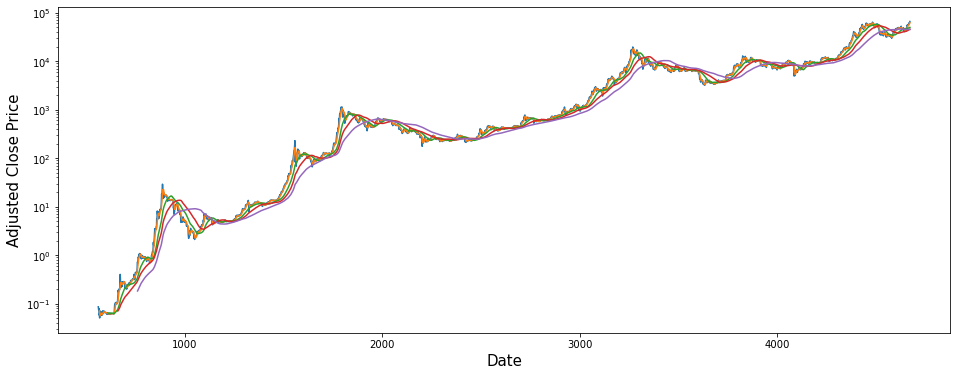

In [ ]:
# Visualize the training stock data:
price_usd = df['BTC / USD Denominated Closing Price']
dma_7 = price_usd.rolling(window=7).mean()
dma_50 = price_usd.rolling(window=50).mean()
dma_100 = price_usd.rolling(window=100).mean()
dma_200 = price_usd.rolling(window=200).mean()


plt.figure(figsize = (16,6))
price_usd.plot(label='PriceUSD')
dma_7.plot(label='7 DMA')
dma_50.plot(label='50 DMA')
dma_100.plot(label='100 DMA')
dma_200.plot(label='200 DMA')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.yscale('log')

plt.show()

### Train Set Vs. SVR(RBF):
Plotting the training data we can see the model struggles to create a multidimensional plane that can separate prices that are orders of magnitude higher than the historical average. 

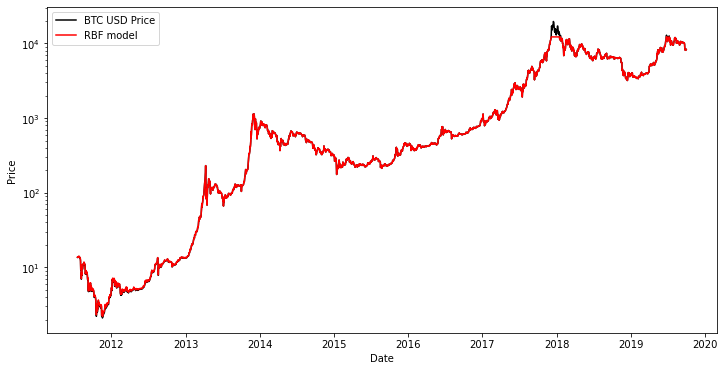

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(X_train.index, y_train, color= 'black', label= 'Price (USD)')
plt.plot(X_train.index, svr_rbf.predict(X_train), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.yscale('log')
plt.show()

### Test Set Vs. SVR(RBF):
Plotting the test data we see is veru difficult for the model to not overfit. 

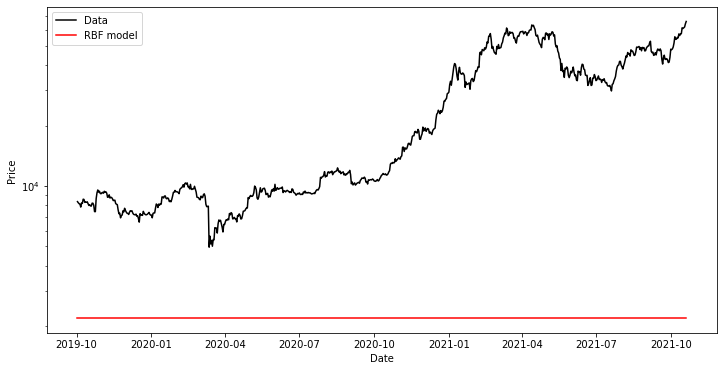

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(X_test.index, y_test, color= 'black', label= 'Data')
plt.plot(X_test.index, svr_rbf.predict(X_test), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.yscale('log')
plt.show()

# SVR with scaled data:

## Transforming, Splitting, and Fitting:

In [294]:
# Splitting with the predefined function for arrays:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scaling_splitting_df(
                                    preprocessing(df, 'Time'), 1, 0.2, StandardScaler())

# Fitting the model:
svr_rbf = SVR(kernel= 'rbf', C= 1e4, gamma= 0.1)
svr_rbf.fit(X_train_scaled, y_train_scaled)

SVR(C=10000.0, gamma=0.1)

## Data Visualization:

### Transformed Price:
Lets plot the original price with different moving averages

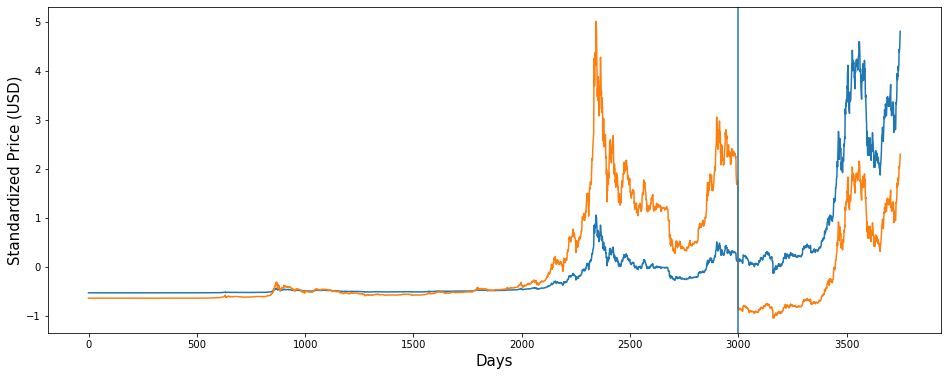

In [304]:
# Visualize the training stock data:
# Scaling the whole series Vs. Scaling Train and Test independently
tot_series_scaled = StandardScaler().fit_transform(preprocessing(df, 'Time'))[:,1]
split_scaled_joined = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
plt.figure(figsize = (16,6))
plt.plot(tot_series_scaled)
plt.plot(split_scaled_joined)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Standardized Price (USD)',fontsize=15)
plt.axvline(x = int(tot_series_scaled.shape[0] * (1 - 0.2)))
# plt.yscale('log')

plt.show()

### Train Set Vs. SVR(RBF):
Plotting the training data we can see the model struggles to create a multidimensional plane that can separate prices that are orders of magnitude higher than the historical average. 

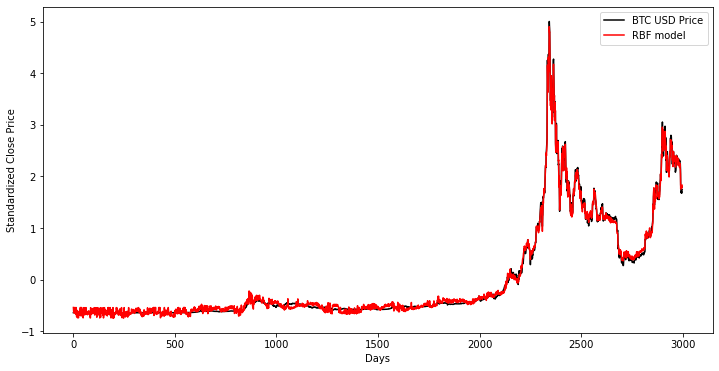

In [308]:
plt.figure(figsize = (12,6))
plt.plot(y_train_scaled, color= 'black', label= 'BTC USD Price')
plt.plot(svr_rbf.predict(X_train_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()

### Test Set Vs. SVR(RBF):
Plotting the test data we see is veru difficult for the model to not overfit. 

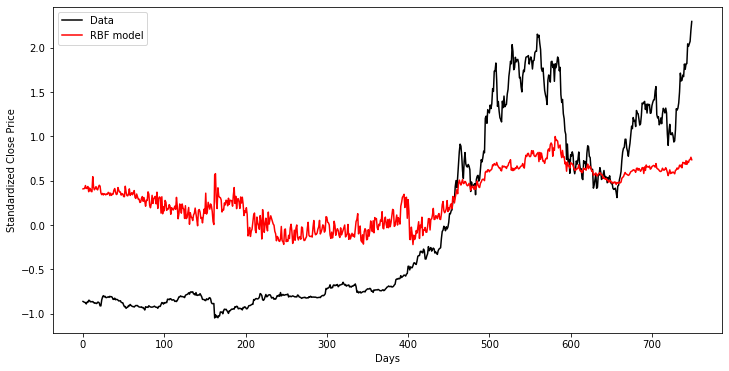

In [306]:
plt.figure(figsize = (12,6))
plt.plot(y_test_scaled, color= 'black', label= 'Data')
plt.plot(svr_rbf.predict(X_test_scaled), color= 'red', label= 'RBF model') 
plt.xlabel('Days')
plt.ylabel('Standardized Close Price')
plt.legend()
# plt.yscale('log')
plt.show()